# **Modeling**

# **Imports**

In [42]:
#Numpy
import numpy as np
from numpy import median

#Pandas
import pandas as pd

#Seaborn
import seaborn as sns

#matplotlib
import matplotlib.pyplot as plt
import plotly

#Sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb

# Set Random seeds for consistent outcomes
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#Scipy
from scipy.sparse import csr_matrix

#Warnings
import warnings
warnings.filterwarnings("ignore")

# **Loading Data**

In [2]:
#Loading in the data from the previous notebook
fd = pd.read_csv('fd')

In [3]:
#Taking a glance at the data to ensure it was laoded properly
fd.head()

,Order #,Transaction Type,Order Time,Order Date,Delivery Date,Product Total,Delivery,Nontaxable Delivery,Wire Out Fee,Discount,Gift Cards,Tax,Tips,Grand Total,Payment Method,Order Type,Order Method,Year
0,100017453,Sale,03:28:16PM Sat,2018-12-29,2018-12-29,815.00,$0.00,0.0,0.0,0.00,0.0,79.46,0.0,894.46,Credit Card,Taken,Phone,2018
1,100017452,Sale,03:16:50PM Sat,2018-12-29,2018-12-29,249.90,$0.00,0.0,0.0,-124.96,0.0,12.19,0.0,137.13,Credit Card,Taken,Walk-In,2018
2,100017451,Sale,02:58:53PM Sat,2018-12-29,2018-12-29,24.95,$0.00,0.0,0.0,0.00,0.0,2.43,0.0,27.38,Credit Card,Taken,Walk-In,2018
3,100017450,Sale,02:54:45PM Sat,2018-12-29,2018-12-29,635.00,$0.00,0.0,0.0,0.00,0.0,61.91,0.0,696.91,Credit Card,Taken,Phone,2018
4,100017202,Sale,02:48:15PM Sat,2018-12-29,2018-12-23,702.00,$0.00,25.0,0.0,0.00,0.0,68.45,0.0,795.45,Credit Card,Delivery,Walk-In,2018


,Order #,Transaction Type,Order Time,Order Date,Delivery Date,Product Total,Delivery,Nontaxable Delivery,Wire Out Fee,Discount,Gift Cards,Tax,Tips,Grand Total,Payment Method,Order Type,Order Method,Year
0,100017453,Sale,03:28:16PM Sat,2018-12-29,2018-12-29,815.00,$0.00,0.0,0.0,0.00,0.0,79.46,0.0,894.46,Credit Card,Taken,Phone,2018
1,100017452,Sale,03:16:50PM Sat,2018-12-29,2018-12-29,249.90,$0.00,0.0,0.0,-124.96,0.0,12.19,0.0,137.13,Credit Card,Taken,Walk-In,2018
2,100017451,Sale,02:58:53PM Sat,2018-12-29,2018-12-29,24.95,$0.00,0.0,0.0,0.00,0.0,2.43,0.0,27.38,Credit Card,Taken,Walk-In,2018
3,100017450,Sale,02:54:45PM Sat,2018-12-29,2018-12-29,635.00,$0.00,0.0,0.0,0.00,0.0,61.91,0.0,696.91,Credit Card,Taken,Phone,2018
4,100017202,Sale,02:48:15PM Sat,2018-12-29,2018-12-23,702.00,$0.00,25.0,0.0,0.00,0.0,68.45,0.0,795.45,Credit Card,Delivery,Walk-In,2018


In [4]:
# Looking at the data types  and ensure there are no missing values
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46062 entries, 0 to 46061
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Order #              46062 non-null  int64  
 1   Transaction Type     46062 non-null  object 
 2   Order Time           46062 non-null  object 
 3   Order Date           46062 non-null  object 
 4   Delivery Date        46062 non-null  object 
 5   Product Total        46062 non-null  float64
 6   Delivery             46062 non-null  object 
 7   Nontaxable Delivery  46062 non-null  float64
 8   Wire Out Fee         46062 non-null  float64
 9   Discount             46062 non-null  float64
 10  Gift Cards           46062 non-null  float64
 11  Tax                  46062 non-null  float64
 12  Tips                 46062 non-null  float64
 13  Grand Total          46062 non-null  float64
 14  Payment Method       46062 non-null  object 
 15  Order Type           46062 non-null 

# **Feature Engineering**

In [5]:
# Filtering out the years 2016 & 2017 because the data for those years is incomplete, and also could be considered irrelevant because of how old it is.
filtered_data = fd[(fd['Year'] != 2016) & (fd['Year'] != 2017)]

In [6]:
#Spliting up the 'Delivery Date' column into indiviual columns for year, month, and day to prepare the data for modeling.
fd['Delivery Date'] = pd.to_datetime(fd['Delivery Date'])
fd['Delivery Year'] = fd['Delivery Date'].dt.year
fd['Delivery Day'] = fd['Delivery Date'].dt.day
fd['Delivery Month'] = fd['Delivery Date'].dt.month

#Spliting up the 'Order Date' column into indiviual columns for year, month, and day to prepare the data for modeling.
fd['Order Date'] = pd.to_datetime(fd['Order Date'])
fd['Order Year'] = fd['Order Date'].dt.year
fd['Order Day'] = fd['Order Date'].dt.day
fd['Order Month'] = fd['Order Date'].dt.month

In [7]:
#Confirming the new columns were formed properly
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46062 entries, 0 to 46061
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Order #              46062 non-null  int64         
 1   Transaction Type     46062 non-null  object        
 2   Order Time           46062 non-null  object        
 3   Order Date           46062 non-null  datetime64[ns]
 4   Delivery Date        46062 non-null  datetime64[ns]
 5   Product Total        46062 non-null  float64       
 6   Delivery             46062 non-null  object        
 7   Nontaxable Delivery  46062 non-null  float64       
 8   Wire Out Fee         46062 non-null  float64       
 9   Discount             46062 non-null  float64       
 10  Gift Cards           46062 non-null  float64       
 11  Tax                  46062 non-null  float64       
 12  Tips                 46062 non-null  float64       
 13  Grand Total          46062 non-

### **More Feature Engineering**

In [8]:
transformed_data = fd

In [9]:
# List of columns to drop
columns_to_drop = ['Tax', 'Wire Out Fee', 'Tips', 'Discount', 'Gift Cards', 'Nontaxable Delivery', 'Order Type', 'Delivery', 'Payment Method', 'Order Method', 'Delivery Date', 'Transaction Type', 'Order Time', 'Order Date', 'Year']
fd.drop(columns=columns_to_drop, inplace=True)
X_reduced = fd

In [10]:
fd = X_reduced
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46062 entries, 0 to 46061
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order #         46062 non-null  int64  
 1   Product Total   46062 non-null  float64
 2   Grand Total     46062 non-null  float64
 3   Delivery Year   46062 non-null  int64  
 4   Delivery Day    46062 non-null  int64  
 5   Delivery Month  46062 non-null  int64  
 6   Order Year      46062 non-null  int64  
 7   Order Day       46062 non-null  int64  
 8   Order Month     46062 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 3.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46062 entries, 0 to 46061
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order #         46062 non-null  int64  
 1   Product Total   46062 non-null  float64
 2   Grand Total     46062 non-null  float64
 3   Delivery 

In [11]:
fd.head()

,Order #,Product Total,Grand Total,Delivery Year,Delivery Day,Delivery Month,Order Year,Order Day,Order Month
0,100017453,815.00,894.46,2018,29,12,2018,29,12
1,100017452,249.90,137.13,2018,29,12,2018,29,12
2,100017451,24.95,27.38,2018,29,12,2018,29,12
3,100017450,635.00,696.91,2018,29,12,2018,29,12
4,100017202,702.00,795.45,2018,23,12,2018,29,12


,Order #,Product Total,Grand Total,Delivery Year,Delivery Day,Delivery Month,Order Year,Order Day,Order Month
0,100017453,815.00,894.46,2018,29,12,2018,29,12
1,100017452,249.90,137.13,2018,29,12,2018,29,12
2,100017451,24.95,27.38,2018,29,12,2018,29,12
3,100017450,635.00,696.91,2018,29,12,2018,29,12
4,100017202,702.00,795.45,2018,23,12,2018,29,12


# **Preprocessing**

### **Validation Split**

In [12]:
# Drop the target column to separate it from the features
X = fd.drop(columns='Grand Total')
y = fd['Grand Total']

In [13]:
#Split training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
#Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy= 'mean')

#Scaler
scaler = StandardScaler()

#OneHotEncoder
ohe =OneHotEncoder(handle_unknown='ignore', sparse=True)

#Create Selectors
cat_selector = make_column_selector(dtype_include= 'object')
num_selector = make_column_selector(dtype_include='number')

# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

#cat pipe
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

#Make tuples for preprocessing the categorical and numeric columns
num_tuple = (numeric_pipe, num_selector)
cat_tuple = (categorical_pipe, cat_selector)          

In [15]:
#Create Column Transformer
preprocessor= make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')

In [16]:
print(X_train.dtypes)

Order #             int64
Product Total     float64
Delivery Year       int64
Delivery Day        int64
Delivery Month      int64
Order Year          int64
Order Day           int64
Order Month         int64
dtype: object
Order #             int64
Product Total     float64
Delivery Year       int64
Delivery Day        int64
Delivery Month      int64
Order Year          int64
Order Day           int64
Order Month         int64
dtype: object


In [17]:
# Preprocess the data
# Fit and transform the preprocessing on the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Transform the test data using the fitted preprocessor
X_test_preprocessed = preprocessor.transform(X_test)

In [18]:
# Looking at how the preprocessor is organized
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000136D2759160>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000136D2759940>)])

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000136D2759160>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000136D2759940>)])

In [19]:
# Ensuring the shape is correct
print("X_train_preprocessed shape:", X_train_preprocessed.shape)
print("y_train shape:", y_train.shape)

X_train_preprocessed shape: (34546, 8)
y_train shape: (34546,)
X_train_preprocessed shape: (34546, 8)
y_train shape: (34546,)


# **Linear Regression Model**

In [20]:
# Create a LinearRegression model
regressor = LinearRegression()

# Train the model using the preprocessed training sets
regressor.fit(X_train_preprocessed, y_train)

# Make predictions for training data
y_predictions_train = regressor.predict(X_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test_preprocessed)

## **Tuning Hyperparameters**

In [21]:
#Function for evaluating Model preformance
def evaluate_model(y_true, y_pred, split='training'):
  """ prints RMSE, and R2 metrics, include which data split was evaluated

  Args:
    y_true: y-train or y-test
    y_pred: result of model.predict(X)
    split: which data split is being evaluate ['training','test']
  """

  r2 = r2_score(y_true,y_pred)
  mae = mean_absolute_error(y_true,y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true,y_pred,squared=False)


  print(f'Results for {split} data:')
  print(f"  - R^2 = {round(r2,3)}")
  print(f"  - MAE = {round(mae,3)}")
  print(f"  - MSE = {round(mse,3)}")
  print(f"  - RMSE = {round(rmse,3)}")
  print()

In [22]:
## Evaluate model's performance
evaluate_model(y_train, y_predictions_train,split='training')
evaluate_model(y_test, y_pred,split='testing')

Results for training data:
  - R^2 = -68730864093.04
  - MAE = 31272481.788
  - MSE = 2770656803286024.5
  - RMSE = 52637028.823

Results for testing data:
  - R^2 = 0.94
  - MAE = 13.926
  - MSE = 1812.342
  - RMSE = 42.572

Results for training data:
  - R^2 = -68730864093.04
  - MAE = 31272481.788
  - MSE = 2770656803286024.5
  - RMSE = 52637028.823

Results for testing data:
  - R^2 = 0.94
  - MAE = 13.926
  - MSE = 1812.342
  - RMSE = 42.572



In [23]:
# Splitting the training set further for hyperparameter tuning
X_train_tune, X_val, y_train_tune, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the parameter grid to search over
param_grid = {
    'fit_intercept': [True, False],  # Whether to calculate the intercept for this model
    'normalize': [True, False],   # Whether to normalize the features before fitting the model
    'copy_X': [True, False],          # Whether to copy the input data; set to False when using larger datasets
    'positive': [True, False]         # Restrict coefficients to be positive
}

# Create the Linear Regression model
model = regressor

# Initialize the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=12, scoring='neg_mean_squared_error')

# Perform the grid search on the training data
grid_search.fit(X_train_tune, y_train_tune)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Predict on the validation set
y_pred_val = best_model.predict(X_val)

# Calculate RMSE for the validation set
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)
print("Root Mean Squared Error (Validation):", rmse_val)

# Now, you can use the best_model to predict on the test set and calculate RMSE
y_pred_test = best_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Root Mean Squared Error (Test):", rmse_test)

Root Mean Squared Error (Validation): 35.49055846857412
Root Mean Squared Error (Test): 42.25580940793254
Root Mean Squared Error (Validation): 35.49055846857412
Root Mean Squared Error (Test): 42.25580940793254


# **Random Forest Regressor model**

In [24]:
#Random forrest Regressor Pipeline
#Fitting the pipeline
rf_tree_pipe = make_pipeline(preprocessor,RandomForestRegressor(random_state = 42))
rf_tree_pipe.fit(X_train, y_train)

## Get predictions for training and test data
y_hat_train = rf_tree_pipe.predict(X_train)
y_hat_test = rf_tree_pipe.predict(X_test)

In [25]:
## Evaluate model's performance
evaluate_model(y_train, y_hat_train,split='training')
evaluate_model(y_test, y_hat_test,split='testing')

Results for training data:
  - R^2 = 0.994
  - MAE = 3.994
  - MSE = 222.182
  - RMSE = 14.906

Results for testing data:
  - R^2 = 0.916
  - MAE = 10.446
  - MSE = 2549.853
  - RMSE = 50.496

Results for training data:
  - R^2 = 0.994
  - MAE = 3.994
  - MSE = 222.182
  - RMSE = 14.906

Results for testing data:
  - R^2 = 0.916
  - MAE = 10.446
  - MSE = 2549.853
  - RMSE = 50.496



## **Tuning Random Forest Regressor**

In [26]:
#create a range of max_depth values
n_estimators = [202, 203, 204, 205, 206, 207, 208]

max_depths = [5, 10, 15] 

#create a dataframe to store train and test scores.
scores = pd.DataFrame(index=n_estimators)

# Loop over the values in n_estimators
for n in n_estimators:
    for max_depth in max_depths:
        # Fit a new model with max_depth
        rf = RandomForestRegressor(random_state=42, n_estimators=n, max_depth=max_depth)

        # Put the model into a pipeline
        rf_pipe = make_pipeline(preprocessor, rf)

        # Fit the model
        rf_pipe.fit(X_train, y_train)

        # Create prediction arrays
        train_pred = rf_pipe.predict(X_train)
        test_pred = rf_pipe.predict(X_test)

        # Evaluate the model using R2 Score
        train_r2score = r2_score(y_train, train_pred)
        test_r2score = r2_score(y_test, test_pred)

        # Store the scores in the scores dataframe
        scores.loc[n, f'Train (max_depth={max_depth})'] = train_r2score
        scores.loc[n, f'Test (max_depth={max_depth})'] = test_r2score

# Print the scores dataframe
print(scores)

     Train (max_depth=5)  Test (max_depth=5)  Train (max_depth=10)  \
202             0.974399            0.911653              0.990024   
203             0.974406            0.911973              0.990024   
204             0.974405            0.912040              0.990017   
205             0.974413            0.911922              0.990034   
206             0.974423            0.911896              0.990054   
207             0.974427            0.911755              0.990068   
208             0.974458            0.911664              0.990088   

     Test (max_depth=10)  Train (max_depth=15)  Test (max_depth=15)  
202             0.915894              0.993594             0.916199  
203             0.916189              0.993593             0.916480  
204             0.916244              0.993586             0.916565  
205             0.916082              0.993601             0.916400  
206             0.916026              0.993621             0.916337  
207             0.9

In [27]:
#Train and test scores
scores

,Train (max_depth=5),Test (max_depth=5),Train (max_depth=10),Test (max_depth=10),Train (max_depth=15),Test (max_depth=15)
202,0.974399,0.911653,0.990024,0.915894,0.993594,0.916199
203,0.974406,0.911973,0.990024,0.916189,0.993593,0.916480
204,0.974405,0.912040,0.990017,0.916244,0.993586,0.916565
205,0.974413,0.911922,0.990034,0.916082,0.993601,0.916400
206,0.974423,0.911896,0.990054,0.916026,0.993621,0.916337
207,0.974427,0.911755,0.990068,0.915912,0.993627,0.916355
208,0.974458,0.911664,0.990088,0.915855,0.993650,0.916240


,Train (max_depth=5),Test (max_depth=5),Train (max_depth=10),Test (max_depth=10),Train (max_depth=15),Test (max_depth=15)
202,0.974399,0.911653,0.990024,0.915894,0.993594,0.916199
203,0.974406,0.911973,0.990024,0.916189,0.993593,0.916480
204,0.974405,0.912040,0.990017,0.916244,0.993586,0.916565
205,0.974413,0.911922,0.990034,0.916082,0.993601,0.916400
206,0.974423,0.911896,0.990054,0.916026,0.993621,0.916337
207,0.974427,0.911755,0.990068,0.915912,0.993627,0.916355
208,0.974458,0.911664,0.990088,0.915855,0.993650,0.916240


In [28]:
#Obtaining the traing and test scores for random forest regression model
best_rf = RandomForestRegressor(random_state = 42, n_estimators = n, max_depth=5)

best_rf_pipe = make_pipeline(preprocessor, best_rf)

best_rf_pipe.fit(X_train, y_train)

print('Training Scores for Random Forest Regressor')
evaluate_model(y_train, best_rf_pipe.predict(X_train), split = 'training')

print('\n')

print('Testing Scores for Random forest Regressor')
evaluate_model(y_test, best_rf_pipe.predict(X_test), split = 'testing')

Training Scores for Random Forest Regressor
Training Scores for Random Forest Regressor
Results for training data:
  - R^2 = 0.974
  - MAE = 12.19
  - MSE = 1029.628
  - RMSE = 32.088



Testing Scores for Random forest Regressor
Results for testing data:
  - R^2 = 0.912
  - MAE = 12.734
  - MSE = 2683.05
  - RMSE = 51.798

Results for training data:
  - R^2 = 0.974
  - MAE = 12.19
  - MSE = 1029.628
  - RMSE = 32.088



Testing Scores for Random forest Regressor
Results for testing data:
  - R^2 = 0.912
  - MAE = 12.734
  - MSE = 2683.05
  - RMSE = 51.798



In [29]:
# Make predictions on the test data (X_test)
y_pred_test = rf_pipe.predict(X_test)

# Calculate Mean Squared Error on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
print("Mean Squared Error (Test Set):", mse_test)

Mean Squared Error (Test Set): 2544.076786043306
Mean Squared Error (Test Set): 2544.076786043306


# **Gradient Boosting Regressor**

In [30]:
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the regressor on the training data
gb_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gb_regressor.predict(X_test)

# Calculate Mean Squared Error on the test set
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 2141.0031974786943
Mean Squared Error: 2141.0031974786943


## **Tuning Gradient Boosting Regressor Hyperparameters**

In [31]:
# Define the parameter grid to search
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 6]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(gb_regressor, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best parameters and best estimator from the random search
best_params = random_search.best_params_
best_regressor = random_search.best_estimator_

# Make predictions on the test data using the best estimator
y_pred = best_regressor.predict(X_test)


# Calculate Mean Squared Error on the test set
mse = mean_squared_error(y_test, y_pred)
print("Best Parameters:", best_params)
print("Mean Squared Error:", mse)


Best Parameters: {'n_estimators': 50, 'min_samples_split': 4, 'max_depth': 3, 'learning_rate': 0.1}
Mean Squared Error: 2198.4788941723173
Best Parameters: {'n_estimators': 50, 'min_samples_split': 4, 'max_depth': 3, 'learning_rate': 0.1}
Mean Squared Error: 2198.4788941723173


In [32]:
#Obtaining the traing and test scores for Gradient Boosting regression model
best_gb = GradientBoostingRegressor(random_state = 42, n_estimators = n, max_depth=5)

best_gb_pipe = make_pipeline(preprocessor, best_gb)

best_gb_pipe.fit(X_train, y_train)

print('Training Scores for Gradient Boosting Regressor')
evaluate_model(y_train, best_gb_pipe.predict(X_train), split = 'training')

print('\n')

print('Testing Scores for Gradient Boosting Regressor')
evaluate_model(y_test, best_gb_pipe.predict(X_test), split = 'testing')

Training Scores for Gradient Boosting Regressor
Results for training data:
  - R^2 = 0.993
  - MAE = 7.929
  - MSE = 269.259
  - RMSE = 16.409



Testing Scores for Gradient Boosting Regressor
Results for testing data:
  - R^2 = 0.927
  - MAE = 10.284
  - MSE = 2215.866
  - RMSE = 47.073

Training Scores for Gradient Boosting Regressor
Results for training data:
  - R^2 = 0.993
  - MAE = 7.929
  - MSE = 269.259
  - RMSE = 16.409



Testing Scores for Gradient Boosting Regressor
Results for testing data:
  - R^2 = 0.927
  - MAE = 10.284
  - MSE = 2215.866
  - RMSE = 47.073



# **LightGBM**

In [33]:
# You can adjust hyperparameters according to your needs
lgb_regressor = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the regressor on the training data
lgb_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lgb = lgb_regressor.predict(X_test)

# Calculate Mean Squared Error on the test set
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
print("LightGBM Mean Squared Error:", mse_lgb)

LightGBM Mean Squared Error: 2396.5998992992063
LightGBM Mean Squared Error: 2396.5998992992063


## **Tuning Hyperparameters**

In [34]:
# Creating a parameter grid for LightGBM
param_grid_lgb = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Creating a LightGBM regressor
lgb_regressor = lgb.LGBMRegressor(random_state=42)

# Creating the GridSearchCV object for LightGBM
grid_search_lgb = GridSearchCV(lgb_regressor, param_grid=param_grid_lgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search_lgb.fit(X_train, y_train)

# Get the best parameters and best estimator for LightGBM
best_params_lgb = grid_search_lgb.best_params_
best_regressor_lgb = grid_search_lgb.best_estimator_

# Make predictions on the test data using the best LightGBM estimator
y_pred_lgb = best_regressor_lgb.predict(X_test)

# Calculate Mean Squared Error for LightGBM on the test set
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
print("LightGBM Best Parameters:", best_params_lgb)
print("LightGBM Mean Squared Error:", mse_lgb)

LightGBM Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
LightGBM Mean Squared Error: 2384.6927620415577
LightGBM Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
LightGBM Mean Squared Error: 2384.6927620415577


# **K-Nearest Neighbors (KNN)**

In [35]:
# You can adjust the number of neighbors (n_neighbors) according to your needs
knn_regressor = KNeighborsRegressor(n_neighbors=5)

# Train the regressor on the training data
knn_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn_regressor.predict(X_test)

# Calculate Mean Squared Error on the test set
mse = mean_squared_error(y_test, y_pred)
print("KNN Mean Squared Error:", mse)

KNN Mean Squared Error: 3060.986796922195
KNN Mean Squared Error: 3060.986796922195


## **Tuning Hyperparameters**

In [38]:
param_dist = {
    'n_neighbors': range(1, 21),  # You can adjust the range of neighbors to search
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create a KNN regressor
knn_regressor = KNeighborsRegressor()

# Create a RandomizedSearchCV instance
random_search = RandomizedSearchCV(
    knn_regressor, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42
)

# Perform the random search on your data
random_search.fit(X_train, y_train)

# Get the best KNN regressor from the search
best_knn_regressor = random_search.best_estimator_

# Make predictions on the test data using the best model
y_pred_best = best_knn_regressor.predict(X_test)

# Calculate Mean Squared Error on the test set for the best model
best_mse = mean_squared_error(y_test, y_pred_best)
print("Best KNN Mean Squared Error:", best_mse)

# Print the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)

Best KNN Mean Squared Error: 2706.0952852630153
Best Hyperparameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 3}
Best KNN Mean Squared Error: 2706.0952852630153
Best Hyperparameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 3}


# **Decision Tree Regressor**

In [36]:
# Create a Decision Tree Regressor.
tree_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)

# Training the regressor on the training data.
tree_regressor.fit(X_train, y_train)

# Making predictions on the test data.
y_pred = tree_regressor.predict(X_test)

# Calculating Mean Squared Error on the test set.
mse = mean_squared_error(y_test, y_pred)
print("Decision Tree Mean Squared Error:", mse)

Decision Tree Mean Squared Error: 2966.136488042898
Decision Tree Mean Squared Error: 2966.136488042898


## **Tuning Decision Tree Regressor Hyperparameters**

In [40]:
# Define the parameter grid to search
param_dist = {
    'max_depth': range(1, 21),          # You can adjust the range of max_depth to search
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a Decision Tree regressor
tree_regressor = DecisionTreeRegressor(random_state=42)

# Create a RandomizedSearchCV instance
random_search = RandomizedSearchCV(
    tree_regressor, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42
)

# Perform the random search on your data
random_search.fit(X_train, y_train)

# Get the best Decision Tree regressor from the search
best_tree_regressor = random_search.best_estimator_

# Make predictions on the test data using the best model
y_pred_best = best_tree_regressor.predict(X_test)

# Calculate Mean Squared Error on the test set for the best model
best_mse = mean_squared_error(y_test, y_pred_best)
print("Best Decision Tree Mean Squared Error:", best_mse)

# Print the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)

Best Decision Tree Mean Squared Error: 1927.3642412154834
Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 9}
Best Decision Tree Mean Squared Error: 1927.3642412154834
Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 9}


# **Neural Networks**

In [ ]:
def eval_regression(model, X, y, name='model'):
    """Returns a dataframe with regression metrics.  
    optional name variable can be used to name each model and/or dataset used 
    for clarity"""
    score_df = pd.DataFrame(index=[name])
    preds = model.predict(X)
    score_df.loc[name,'MAE'] = mean_absolute_error(y, preds)
    score_df.loc[name,'RMSE'] = np.sqrt(mean_squared_error(y, preds))
    score_df.loc[name,'R2'] = r2_score(y, preds)
    return score_df

def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [ ]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Instantiate the sequential model

reg_model = Sequential()
# use all features as input using input_dim
input_dim = X_train.shape[1]

# Add first hidden layer
reg_model.add(Dense(units=64, activation='relu', input_shape=(input_dim,)))
reg_model.add(Dense(units=1, activation='linear'))
# Add output layer with 1 node
reg_model.add(Dense(1, activation='linear', name ='output'))


# Check summary of network 
reg_model.summary()

In [ ]:
# Compile the model.
rmse = RootMeanSquaredError(name='rmse')

reg_model.compile(loss='mean_squared_error', optimizer='adam', metrics= ['mae', rmse])

In [ ]:
# Fit the model

history = reg_model.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 100, batch_size=32, verbose=1)


In [ ]:
train_scores = eval_regression(reg_model, 
                         X_train, 
                         y_train, 
                         name='reg_model1 Train')
test_scores = eval_regression(reg_model, 
                                       X_test, 
                                       y_test, 
                                       name='reg_model1 test')
scores1 = pd.concat([train_scores, test_scores])
scores1

In [ ]:
# Create a Sequential model
model = Sequential()

# Add input and hidden layers
model.add(Dense(64, input_dim=1, activation='relu'))
model.add(Dense(32, activation='relu'))

# Add output layer
model.add(Dense(1, activation='linear'))

In [ ]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model on the training data
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate Mean Squared Error on the test set
mse = mean_squared_error(y_test, y_pred)
print("Neural Network Mean Squared Error:", mse)

## **Tuning Hyperparameters**

# **Time Series Predictive Model**

Actual: 233.35  Predicted: 238.70
Actual: 257.01  Predicted: 241.55
Actual: 255.66  Predicted: 244.40
Actual: 238.64  Predicted: 247.25
Actual: 271.88  Predicted: 250.11
Actual: 278.96  Predicted: 252.96
Actual: 274.79  Predicted: 255.81
Actual: 264.20  Predicted: 258.66
Actual: 258.29  Predicted: 261.51
Actual: 282.54  Predicted: 264.37
Actual: 270.97  Predicted: 267.22
Actual: 290.22  Predicted: 270.07
Actual: 283.08  Predicted: 272.92
Actual: 293.77  Predicted: 275.77
Actual: 290.56  Predicted: 278.62
Actual: 297.07  Predicted: 281.48
Actual: 293.11  Predicted: 284.33
Actual: 313.86  Predicted: 287.18
Actual: 300.27  Predicted: 290.03
Actual: 306.02  Predicted: 292.88
Actual: 233.35  Predicted: 238.70
Actual: 257.01  Predicted: 241.55
Actual: 255.66  Predicted: 244.40
Actual: 238.64  Predicted: 247.25
Actual: 271.88  Predicted: 250.11
Actual: 278.96  Predicted: 252.96
Actual: 274.79  Predicted: 255.81
Actual: 264.20  Predicted: 258.66
Actual: 258.29  Predicted: 261.51
Actual: 282.54

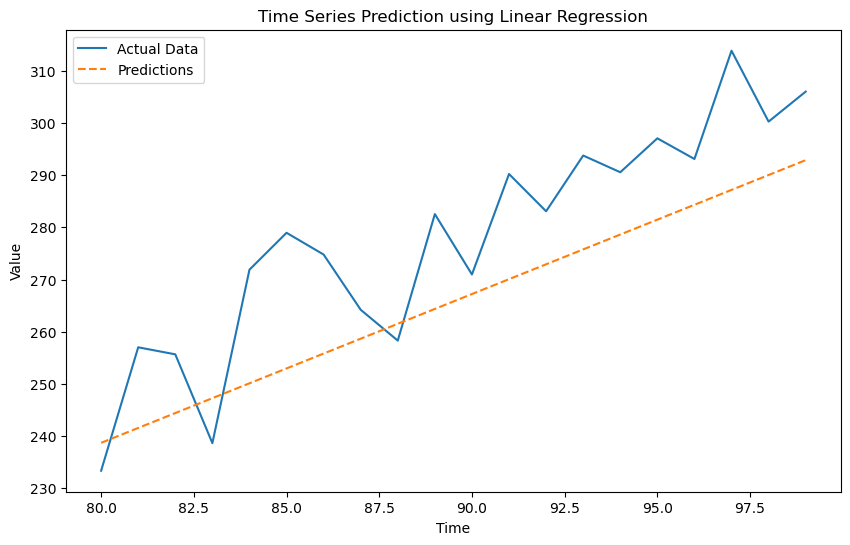

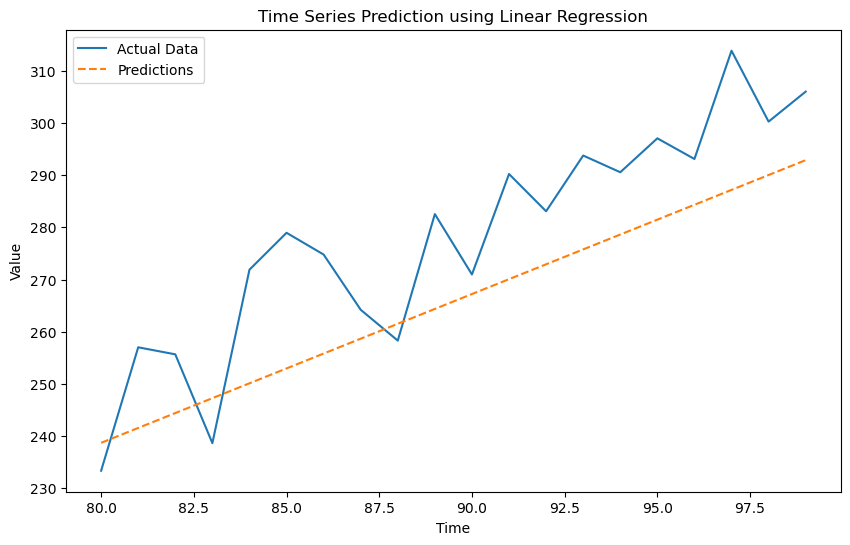

In [39]:
# Generate some sample time series data
np.random.seed(0)
n_samples = 100
time = np.arange(n_samples)
data = 3 * time + 5 + np.random.normal(0, 10, n_samples)
# Split the data into train and test sets
train_size = int(0.8 * n_samples)
train_data, test_data = data[:train_size], data[train_size:]
train_time, test_time = time[:train_size], time[train_size:]
# Reshape the data for scikit-learn
X_train = train_time.reshape(-1, 1)
y_train = train_data
X_test = test_time.reshape(-1, 1)
y_test = test_data
# Create a linear regression model
model = LinearRegression()
# Train the model
model.fit(X_train, y_train)
# Make predictions for the test set
predictions = model.predict(X_test)
# Display the actual values and predictions
for actual, predicted in zip(y_test, predictions):
    print(f"Actual: {actual:.2f}  Predicted: {predicted:.2f}")
# Plot the actual data and predictions
plt.figure(figsize=(10, 6))
plt.plot(test_time, y_test, label='Actual Data')
plt.plot(test_time, predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Prediction using Linear Regression')
plt.show()

# **Save Predictions**

In [ ]:
#Saving the new dataframe to upload in the next notebook
fd.to_csv('Predictions', index=False)